In [1]:
import os, sys, copy
sys.path.append("../")
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import pickle
from matplotlib import pyplot as plt
%matplotlib inline

In [18]:
from modules.Interproc import GuiviewState
from modules.Interproc import DBInterface
from modules.ControlTracking import TrackFactory
from modules.ControlDisplay import Display

In [96]:
from modules.AnalysisHelpers import (applyTracker, multiPlot,
                                     roiSelectZoomWindow
                                    ,checkTrackSuccess)

### Load Data

In [65]:
# set b_reload to True to load data from book specific databse
# if False, load guiview states manually from guiview
b_reload = False

In [66]:
# INIT ONCE HERE
if b_reload:
    db = DBInterface("../data/misc/books/demo-interproc-analysis-2/data.db")
else:
    db = DBInterface("../data/usr/interproc.db")
    listGS = []

#### manually load data

In [71]:
if not(b_reload):
    # currently frames: 0, 198, 312
    listGS.append( pickle.loads(db.selectLatest()[0][1]) )

In [72]:
[_gs.frameCounter for _gs in listGS]

[0, 189, 312]

In [74]:
gs.zoomRect

(192.0, 150.0, 66.0, 68.0)

#### save the data to book's database

In [30]:
comparisonSets = []

In [81]:
saveDB.deleteAll()

In [82]:
saveDB.getIds()

[]

In [83]:
if not(b_reload):
    
    pathDB = "../data/misc/books/demo-interproc-analysis-2/data.db"
    
    saveDB = DBInterface(pathDB)
    
    comparisonSet = []
    
    for gs in listGS:
        
        _id = saveDB.insertStateGetId(gs.save())
        
        comparisonSet.append(_id)
    
    print comparisonSet

[1, 2, 3]


In [84]:
#Use this save comparison sets
comparisonSets.append(comparisonSet)
print comparisonSets

[[1, 2, 3], [1, 2, 3]]


#### load data from book's database

In [48]:
b_reload = True
comparison_ind = 0
compare_ids = comparisonSets[comparison_ind]

if b_reload:
    
    db = DBInterface("../data/misc/books/demo-interproc-analysis-2/data.db")
    
    all_data = db.selectAll()
    
    compare_data = filter(lambda record: record[0] in compare_ids, all_data)
    
    listGS = [ pickle.loads(compare_datum[1]) 
                for compare_datum in compare_data
             ]
    
    #validate
    print [_gs.frameCounter for _gs in listGS]

[0, 189, 312]


## Do analysis

In [75]:
tracker = TrackFactory(on=True)

tracker.setInit(ballColor = "green")

tracker.getTrackParams()

{'repair_iterations': 1,
 'thresh_hi': (64, 255, 255),
 'thresh_lo': (29, 86, 6),
 'tracking_blur': 1}

In [76]:
from modules.AnalysisHelpers import applyTracker, roiSelectZoomWindow

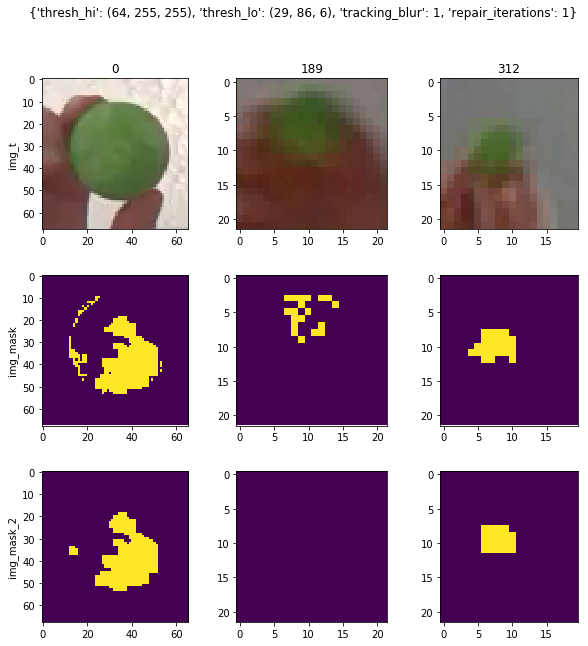

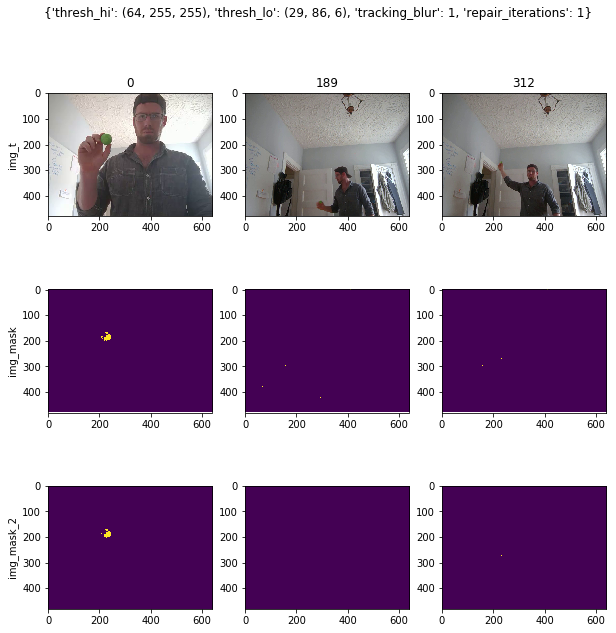

In [89]:
#frame= zoom window
data = applyTracker(listGS, tracker, roiSelectZoomWindow)

multiPlot( list_list_imgs = data['listPlts']
          ,input_frame_titles = data['listFrameTitles']
          ,input_transform_titles = data['listTransformTitles']
          ,input_figure_title = str(tracker.getTrackParams())
         )

#frame=whole frame
data = applyTracker(listGS, tracker)

multiPlot( list_list_imgs = data['listPlts']
          ,input_frame_titles = data['listFrameTitles']
          ,input_transform_titles = data['listTransformTitles']
          ,input_figure_title = str(tracker.getTrackParams())
         )

## Loop for parameter hunt

In [101]:
loopLog = []

targetGS = [listGS[1]]

for i in range(3):
    
    iterLog = {}
    iterLog['i'] = i
    
    tracker = TrackFactory(on=True)
    tracker.setAlgoEnum(1)
    tracker.setInit(ballColor = "green")
    
    if i == 0:
        thresh_lo = (29,66,6)
    elif i == 1:
        thresh_lo = (29,86,6)
    elif i == 2:
        thresh_lo = (29,106,6)
        
    tracker.setTrackParams(thresh_lo = thresh_lo)
    
    iterLog['track_params'] = tracker.getTrackParams()
    
    outcomeData = applyTracker(targetGS, tracker, bLogPlts=False)
    
    score = outcomeData['listScore'][0]
    
    iterLog['success'] = checkTrackSuccess(score)
    
    loopLog.append(iterLog)
    
loopLog

[{'i': 0,
  'success': True,
  'track_params': {'repair_iterations': 1,
   'thresh_hi': (64, 255, 255),
   'thresh_lo': (29, 66, 6),
   'tracking_blur': 1}},
 {'i': 1,
  'success': False,
  'track_params': {'repair_iterations': 1,
   'thresh_hi': (64, 255, 255),
   'thresh_lo': (29, 86, 6),
   'tracking_blur': 1}},
 {'i': 2,
  'success': False,
  'track_params': {'repair_iterations': 1,
   'thresh_hi': (64, 255, 255),
   'thresh_lo': (29, 106, 6),
   'tracking_blur': 1}}]

In [119]:
# build gradient
paramSpace = []

delta_a = 5
range_a = 5
baseline_a = (29,86,6)
index_a = 1
name_a = 'thresh_lo'

gradient_a = [_delta for _delta in range(-delta_a * range_a
                                         ,delta_a * (range_a + 1)
                                         ,delta_a)
             ]

space_a = []

for _gradient in gradient_a:
    _point = list(baseline_a)
    _point[index_a] = _point[index_a] + _gradient
    space_a.append(tuple(_point))
    
space_a

points_a = [{name_a:val} for val in space_a]

paramSpace.extend(points_a)

paramSpace

[{'thresh_lo': (29, 61, 6)},
 {'thresh_lo': (29, 66, 6)},
 {'thresh_lo': (29, 71, 6)},
 {'thresh_lo': (29, 76, 6)},
 {'thresh_lo': (29, 81, 6)},
 {'thresh_lo': (29, 86, 6)},
 {'thresh_lo': (29, 91, 6)},
 {'thresh_lo': (29, 96, 6)},
 {'thresh_lo': (29, 101, 6)},
 {'thresh_lo': (29, 106, 6)},
 {'thresh_lo': (29, 111, 6)}]

In [127]:
def buildGradient(
          name
         ,baseline
         ,index = None
         ,delta = 5
         ,steps = 5
         ,validMin = None
         ,validMax = None
        ):
    '''
        build a gradient for variable of interest
        
        returns: list of dicts
        
            [{name: val_gradient=0}, {name: val_gradient=1}, ...]
        
        if variable is a tuple, use 'index' arg to alter only
        this variable within the tuple, and validate on it.
        
        if validXX is not None, checks _validPoint against
        this condition to consider adding it to gradient output.
        
        TODO:
            index as list of indexes - can't be done with this function
            will need to combine dicts later on
    '''
    
    gradient = [x for x in range(-delta * steps
                                 ,delta * (steps + 1)
                                 ,delta)
               ]
    
    space = []

    for _gradient in gradient:
        
        if index is None:
            
            # scalar variables
            
            _point = baseline + _gradient
            
            _validPoint = _point
            
        else:
            
            #tuple variables
            
            _point = list(baseline)
            
            _point[index_a] = _point[index_a] + _gradient
            
            _point = tuple(_point)
            
            _validPoint = _point[index_a]
                        
            
        #validation
        if validMin is not None:
            if _validPoint < validMin:
                continue
                
        if validMax is not None:
            if _validPoint > validMax:
                continue
        
        space.append(_point)

    points_a = [{name:val} for val in space]
    
    return points_a

In [132]:
gradient_1 = buildGradient( 
               name='thresh_lo'
              ,baseline= (29,86,6)
              ,index = 1
              ,validMin = 0
              ,validMax = 255
             )
gradient_1

[{'thresh_lo': (29, 61, 6)},
 {'thresh_lo': (29, 66, 6)},
 {'thresh_lo': (29, 71, 6)},
 {'thresh_lo': (29, 76, 6)},
 {'thresh_lo': (29, 81, 6)},
 {'thresh_lo': (29, 86, 6)},
 {'thresh_lo': (29, 91, 6)},
 {'thresh_lo': (29, 96, 6)},
 {'thresh_lo': (29, 101, 6)},
 {'thresh_lo': (29, 106, 6)},
 {'thresh_lo': (29, 111, 6)}]

In [133]:
gradient_2 = buildGradient( 
               name='repair_iterations'
              ,baseline= 1
              ,delta = 1
              ,steps = 2
              ,validMin = 0
              ,validMax = 20
             )
gradient_2

[{'repair_iterations': 0},
 {'repair_iterations': 1},
 {'repair_iterations': 2},
 {'repair_iterations': 3}]

In [137]:
from itertools import combinations, product

In [180]:
a = [range(4), range(3)]
[x for x in product(*a)]

[(0, 0),
 (0, 1),
 (0, 2),
 (1, 0),
 (1, 1),
 (1, 2),
 (2, 0),
 (2, 1),
 (2, 2),
 (3, 0),
 (3, 1),
 (3, 2)]

In [173]:
def combineDicts(*args):
    d = {}
    for elem in args:
        for k in elem.keys():
            d[k] = elem[k]
    return d

In [174]:
a = {'a':1}
b = {'b':2, 'c':3}
x = [a,b]
combineDicts(*x)

{'a': 1, 'b': 2, 'c': 3}

In [175]:
def combineGradient(listGradients):
    
    output = []
    
    dims = [len(gradientG) for gradientG in listGradients]
    
    xdims = [range(x) for x in dims]
    
    for _p in product(*xdims):
        
        gInd = [(i,v) for i,v in enumerate(_p)]
        
        dicts = [ listGradients[_ind[0]][_ind[1]] for _ind in gInd]
        
        output.append( combineDicts(*dicts) )
        
    return output


In [179]:
grads = [gradient_1, gradient_2]
paramSpace = combineGradient(grads)
print len(paramSpace)
paramSpace[3:8]

44


[{'repair_iterations': 3, 'thresh_lo': (29, 61, 6)},
 {'repair_iterations': 0, 'thresh_lo': (29, 66, 6)},
 {'repair_iterations': 1, 'thresh_lo': (29, 66, 6)},
 {'repair_iterations': 2, 'thresh_lo': (29, 66, 6)},
 {'repair_iterations': 3, 'thresh_lo': (29, 66, 6)}]

In [190]:
loopLog = []
i = 0

targetGS = [listGS[1]]

for paramPoint in paramSpace:
    
    iterLog = {}
    
    iterLog['i'] = i
    i += 1
    
    tracker = TrackFactory(on=True)
    tracker.setAlgoEnum(1)
    tracker.setInit(ballColor='green')
    tracker.setTrackParams(**paramPoint)
    
    iterLog['track_params'] = tracker.getTrackParams()
    
    outcomeData = applyTracker(targetGS, tracker, bLogPlts=False)
    
    score = outcomeData['listScore'][0]
    
    iterLog['success'] = checkTrackSuccess(score)
    
    loopLog.append(iterLog)
    

In [191]:
goodParams = filter(lambda elem: elem['success'] , loopLog)
print len(goodParams)

18


In [192]:
inputParams = [log['track_params'] for log in goodParams]
inputParams[0]

{'repair_iterations': 0,
 'thresh_hi': (64, 255, 255),
 'thresh_lo': (29, 61, 6),
 'tracking_blur': 1}

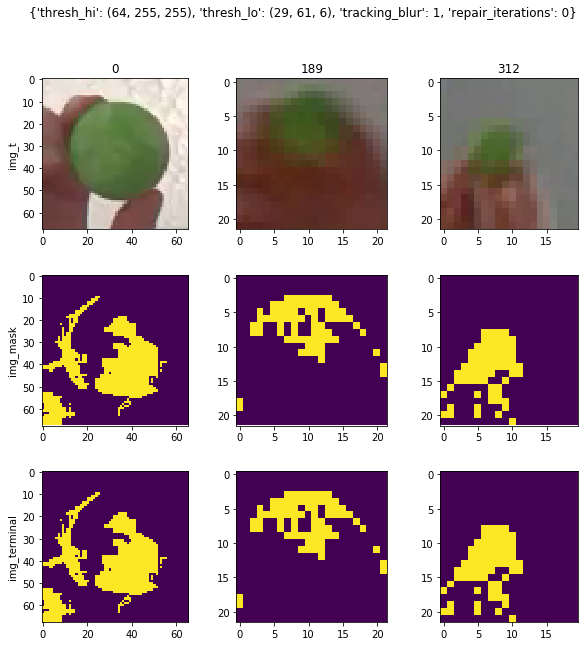

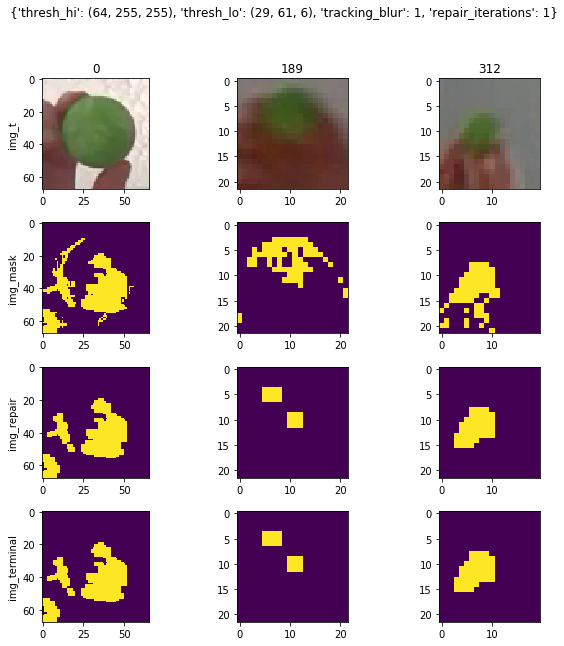

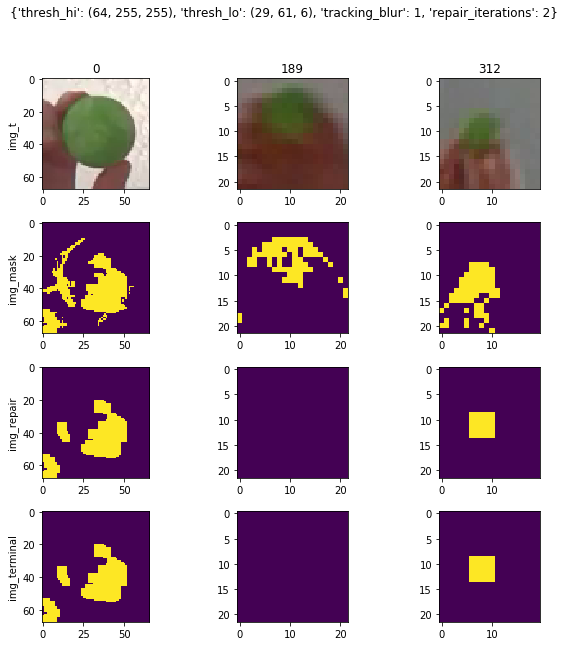

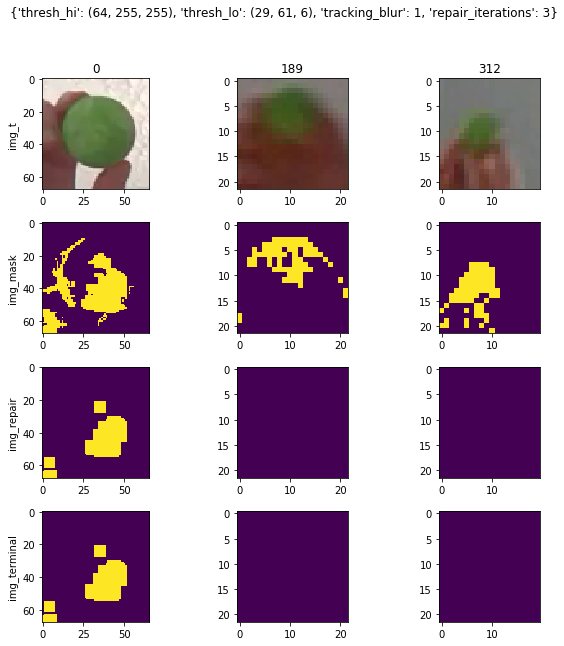

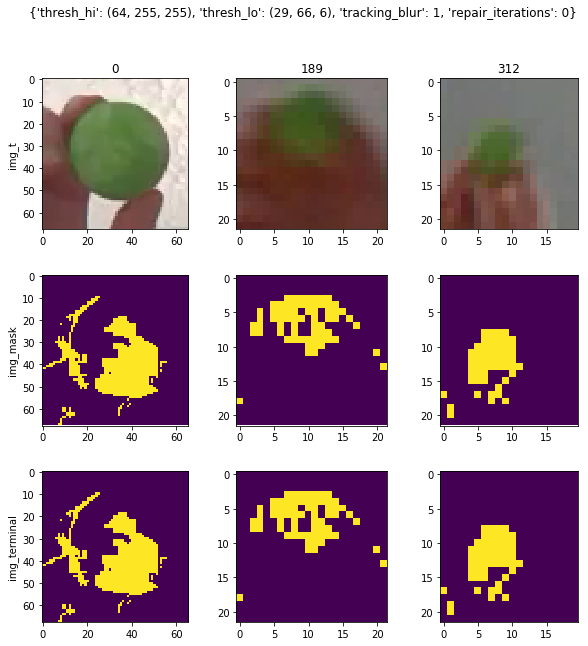

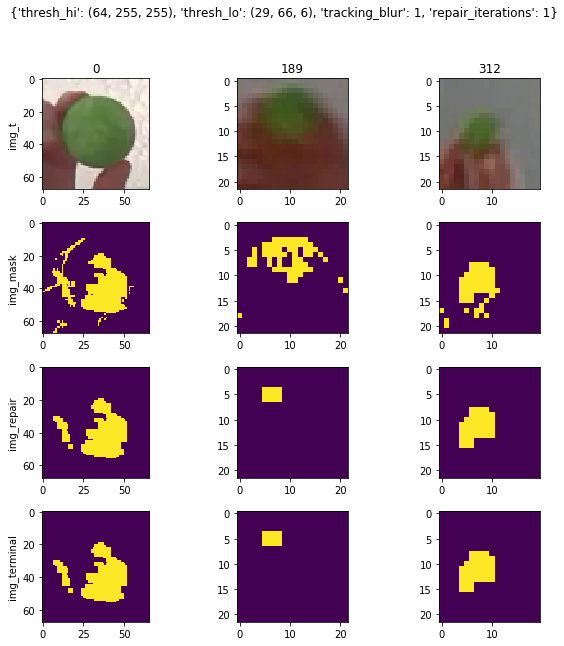

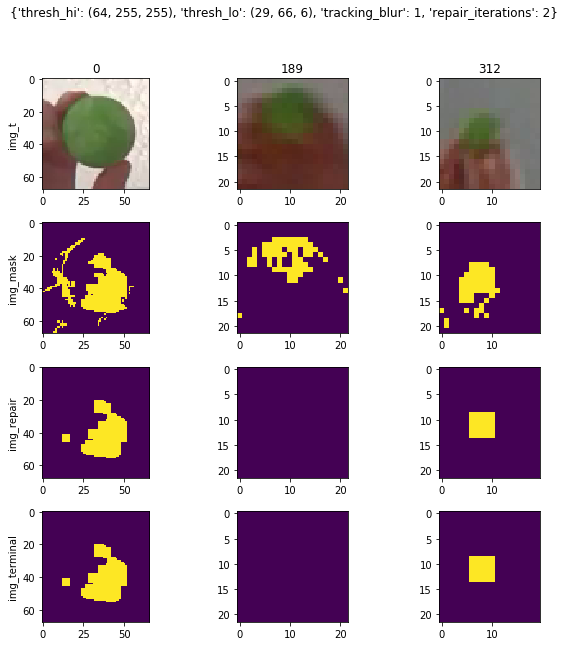

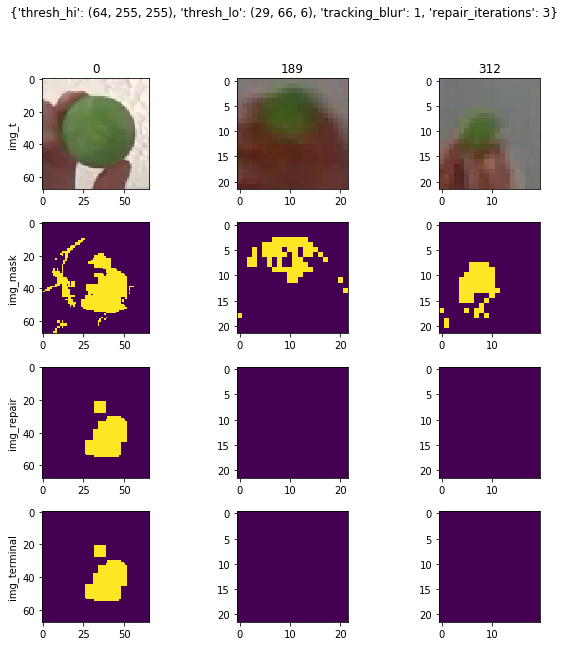

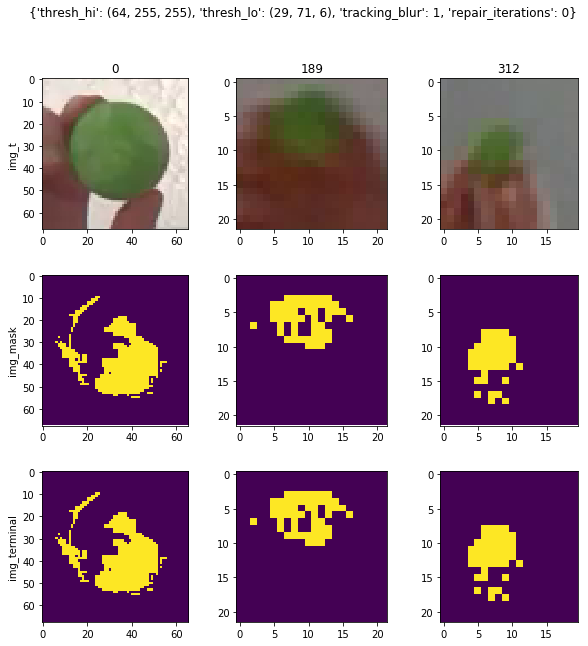

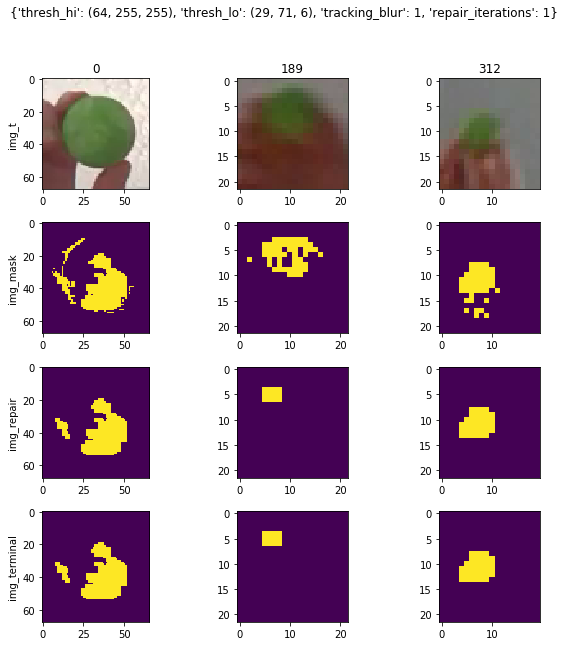

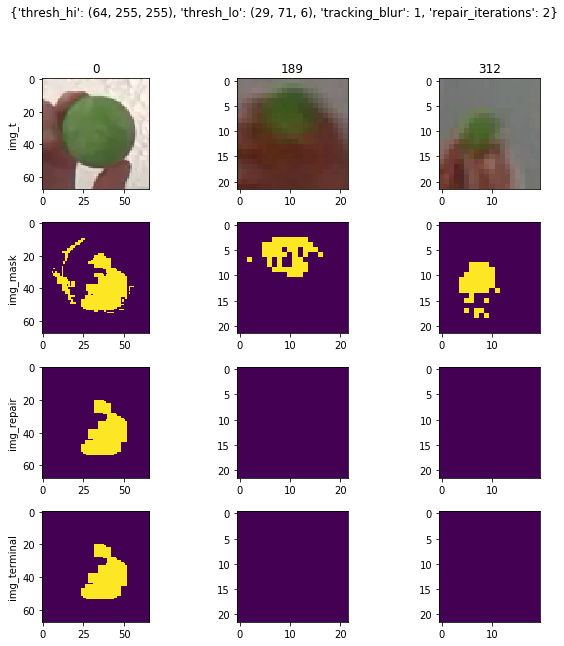

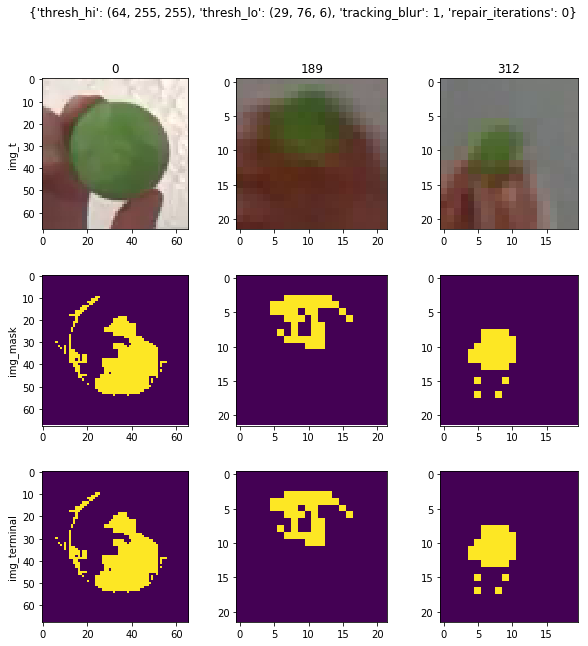

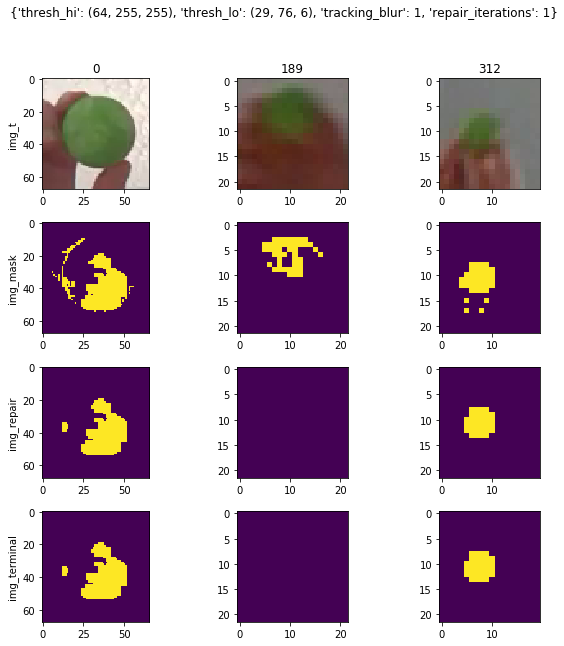

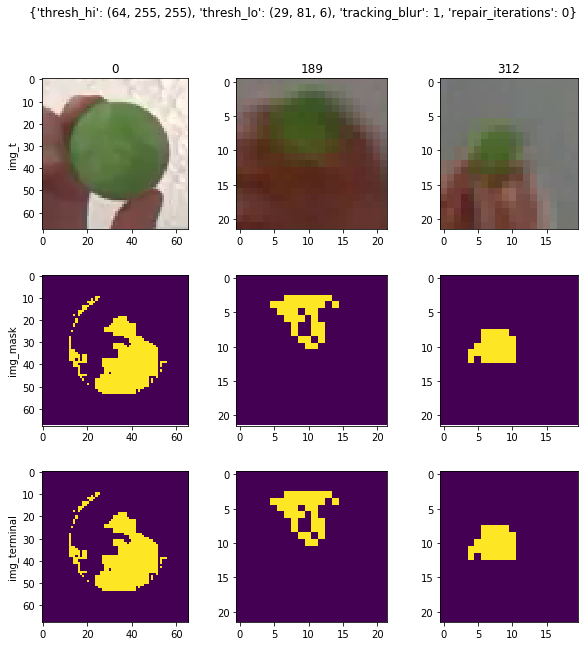

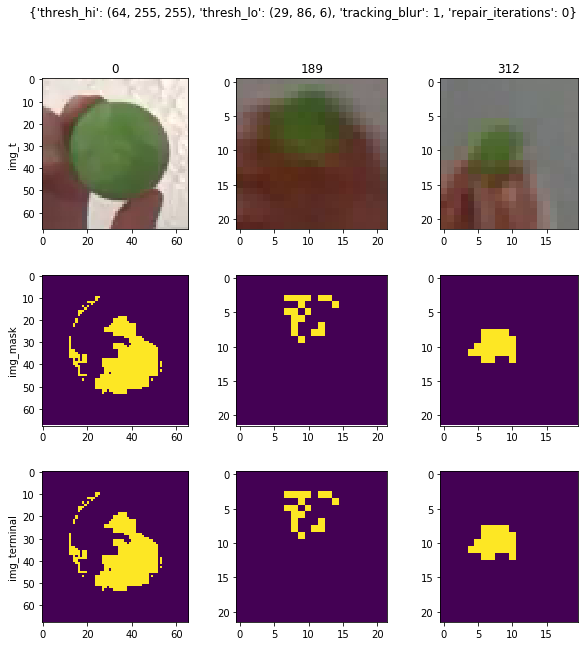

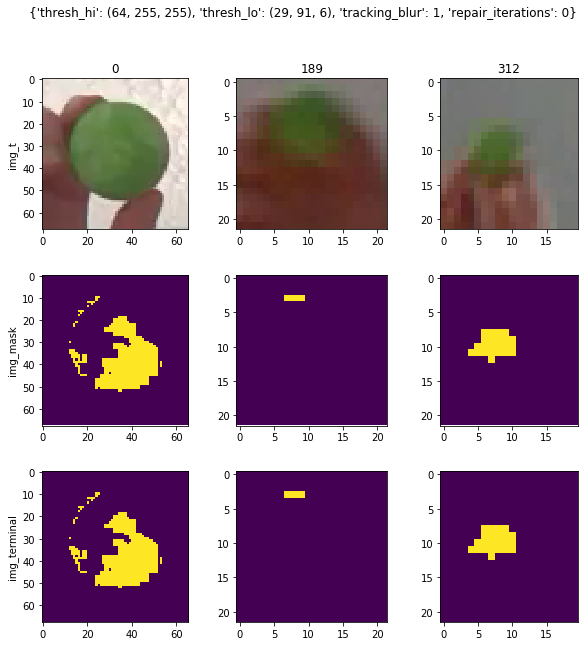

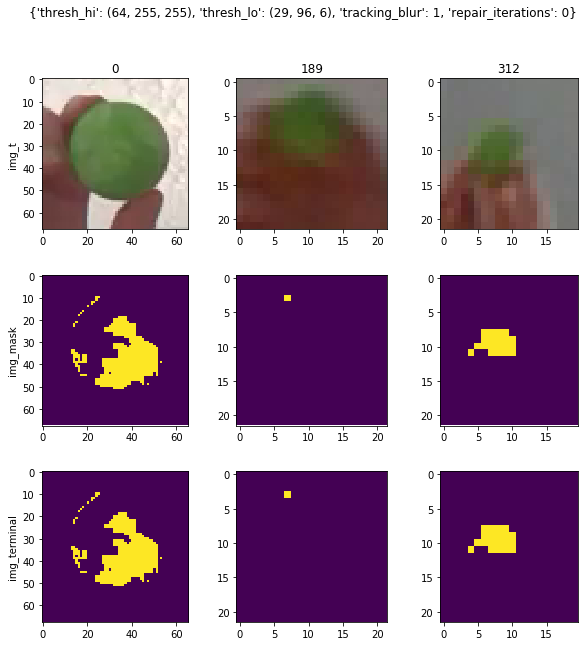

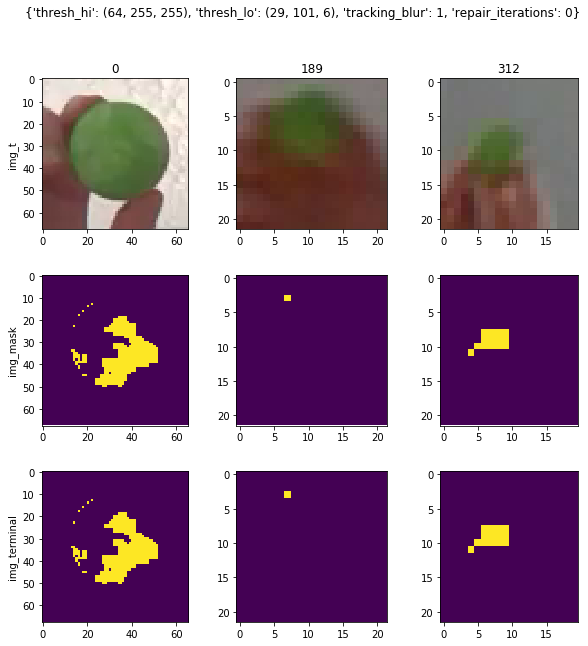

In [193]:
for _inputParam in inputParams:
    
    tracker = TrackFactory(on=True)
    tracker.setAlgoEnum(1)
    tracker.setTrackParams(**_inputParam)
    
    data = applyTracker(listGS, tracker, roiSelectZoomWindow)

    multiPlot( list_list_imgs = data['listPlts']
              ,input_frame_titles = data['listFrameTitles']
              ,input_transform_titles = data['listTransformTitles']
              ,input_figure_title = str(tracker.getTrackParams())
             )